<a href="https://colab.research.google.com/github/pahanmendis/EN2550/blob/main/EN2550_2021_Object_Counting_on_a_Convey_Belt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EN2550 2021: Object Counting on a Convey Belt**

In this assignment, you will be counting and tracking the hexagonal nuts on a moving convey belt


 **Let's first import required libraries**


In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


%matplotlib inline

Let's load and visualize the template image and the convey belt snapshot at a given time.




In [2]:
template = r'/content/drive/MyDrive/Computer Vision/Assignment05/template.png'
belt = r'/content/drive/MyDrive/Computer Vision/Assignment05/belt.png'

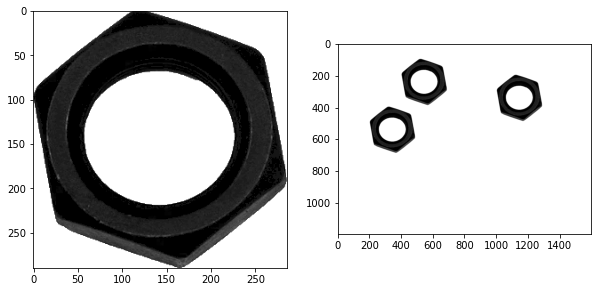

In [3]:
template_im = cv.imread(template, cv.IMREAD_GRAYSCALE)
belt_im =  cv.imread(belt, cv.IMREAD_GRAYSCALE)

#viewing the images
fig, ax = plt. subplots(1,2,figsize=(10,10))
ax[0].imshow(template_im, cmap='gray')
ax[1].imshow(belt_im, cmap='gray')
plt.show()

# **Part-I :**
Before going into the implementation, let's play with some functions.

# **Otsu's thresholding**
Please read [thresholding](https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html) to get an idea about different types of thresholding and how to use them.(Please use `cv.THRESH_BINARY_INV`).

There are 3 main types of thresholding.
1. **Simple thresholding** - For every pixel, the same threshold value is applied. If the pixel value is smaller than the threshold, it is set to 0, otherwise it is set to a maximum value.
2. **Adaptive thresholding** - Determines the threshold for a pixel based on a small region around it
3. **Otsu's thresholding** - In global thresholding, we used an arbitrary chosen value as a threshold. In contrast, Otsu's method avoids having to choose a value and determines it automatically.

In [4]:
th_t, img_t = cv.threshold(template_im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
th_b, img_b = cv.threshold(belt_im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

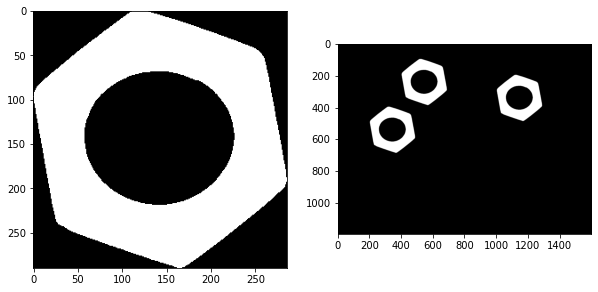

In [5]:
fig, ax = plt. subplots(1,2,figsize=(10,10))
ax[0].imshow(img_t, cmap='gray')
ax[1].imshow(img_b, cmap='gray')
plt.show()

## **Morphological closing**
Carry out morphological closing to remove small holes inside the foreground. Use a 
3
×
3
 kernel. See [closing](https://docs.opencv.org/master/d9/d61/tutorial_py_morphological_ops.html) for a guide.

Closing can be defined as Dilation followed by Erosion. Useful in closing small holes inside the foreground objects, or small black points on the object

Erosion - Erodes away the boundary of the foreground object

Dilation - Increases the white region.

In [6]:
#kernel = #"< 3x3 matrix with all ones, with uint8 dtype>" 

kernel = np.ones((3,3),np.uint8) #defining the kernal to indicate the number of neighbouring pixels we consider.
closing_t = cv.morphologyEx(img_t, cv.MORPH_CLOSE, kernel)
closing_b = cv.morphologyEx(img_b, cv.MORPH_CLOSE, kernel)

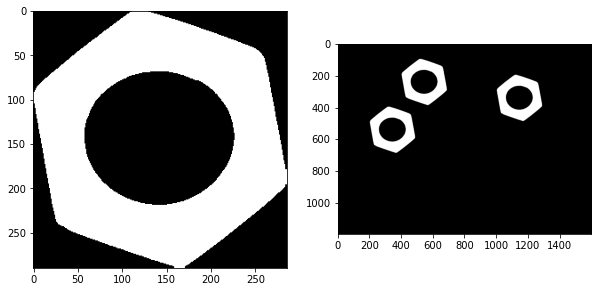

In [7]:
#viewing the result
fig, ax = plt. subplots(1,2,figsize=(10,10))
ax[0].imshow(closing_t, cmap='gray')
ax[1].imshow(closing_b, cmap='gray')
plt.show()

# **Connected component analysis**
Apply the connectedComponentsWithStats function ( [see this](https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#ga107a78bf7cd25dec05fb4dfc5c9e765f)).

`cv.conectedComponents` computes the connected components labeled image of boolean image and also produces a statistics output for each label

this function outputs - retval, labels, stats, centroids
1. retvals - number of components identified
2. labels -	destination labeled image
3. stats -	statistics output for each label, including the background label. Statistics are accessed via stats(label, COLUMN) where COLUMN is one of ConnectedComponentsTypes, selecting the statistic. The data type is CV_32S.
4. centroids -	centroid output for each label, including the background label. Centroids are accessed via centroids(label, 0) for x and centroids(label, 1) for y. The data type CV_64F.

In [8]:
retval_t, labels_t, stats_t, centroids_t = cv.connectedComponentsWithStats(closing_t)
retval_b, labels_b, stats_b, centroids_b = cv.connectedComponentsWithStats(closing_b)

*   How many connected compoonets are detected in each image?

In [9]:
print("number of connected components: ",retval_b)

number of connected components:  4


*   What are the statistics? Interpret these statistics.

* What are the centroids?

In [10]:
print("centroids")
print(centroids_b)

centroids
[[ 807.85728475  614.56805258]
 [ 542.82567158  243.78479797]
 [1142.82567158  343.78479797]
 [ 342.82567158  543.78479797]]



# **Contour analysis**
Use findContours function to retrieve the extreme outer contours. ( [see](https://docs.opencv.org/4.5.2/d4/d73/tutorial_py_contours_begin.html) for help and [see](https://docs.opencv.org/4.5.2/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0) for information.)

`cv.findContours` - Finds the countours in the binary image and returns 2 parameters.
1. contours	- Detected contours. Each contour is stored as a vector of points (e.g. std::vector<std::vector<cv::Point> >).
2. hierarchy	- Optional output vector (e.g. std::vector<cv::Vec4i>), containing information about the image topology.

Display these countours.

In [11]:
contours_t, hierarchy_t = cv.findContours(closing_t, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contours_b, hierarchy_b = cv.findContours(closing_b, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

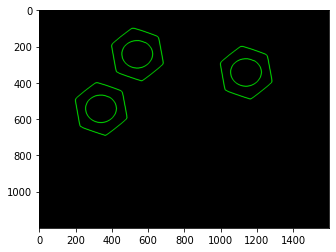

In [12]:
# Visualizing contours
im_contours_belt = np.zeros((belt_im.shape[0],belt_im.shape[1],3), np.uint8)
conts = cv.drawContours(im_contours_belt, contours_b, -1, (0,255,0), 3).astype('uint8')
plt.imshow(conts)

# **Count the number of matching hexagonal nuts in belt.png.**

Use the `matchShapes` function as shown in [examples](https://https://docs.opencv.org/4.5.2/d5/d45/tutorial_py_contours_more_functions.html) to match contours in the belt image with that in the template.

Get an idea about the value output by the `cv.matchShapes` when both the template and the reference image have the same shape. Understand the given code snippet.

`cv.matchShapes` - compare two shapes, or two contours and returns a metric showing the similarity. The lower the result, the better match it is.

In [13]:
label = 1 # remember that the label of the background is 0
belt = ((labels_b >= label)*255).astype('uint8')   
belt_cont, template_hierarchy = cv.findContours(belt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
print("match results of each contour with the template")
objectNum=0  
for j,c in enumerate(belt_cont):
        print("Object",objectNum,":",cv.matchShapes(contours_t[0], c, cv.CONTOURS_MATCH_I1, 0.0))
        objectNum+=1

match results of each contour with the template
Object 0 : 0.00010071698397151607
Object 1 : 0.00010071698397928763
Object 2 : 0.00010071698397484674


# **Part - II**
Frame tracking through image moments.
Use the `cv.contourArea()`, see [this](https://docs.opencv.org/master/dd/d49/tutorial_py_contour_features.html) and calculate the the area of the `contours_b[1]`

In [14]:
cnt=contours_b[1]
ca = cv.contourArea(cnt)
print(ca)

20080.0


Use the `cv.moments` to extract the x and y coordinates of the centroid of `contours_b[1]`.

In [15]:
M = cv.moments(cnt)
print(M)
cx, cy = int(M['m10']/M['m00']),int(M['m01']/M['m00'])
print(cx,cy)

{'m00': 20080.0, 'm10': 6857249.333333333, 'm01': 10902219.5, 'm20': 2377821838.6666665, 'm11': 3722971235.5, 'm02': 5947774212.166666, 'm30': 836677775088.6001, 'm21': 1290927450455.1833, 'm12': 2031031745454.1167, 'm03': 3260276110202.5503, 'mu20': 36095323.75130558, 'mu11': -98356.04525279999, 'mu02': 28531680.98238945, 'mu30': 7133283.688598633, 'mu21': -18102990.339790344, 'mu12': -5413550.269262314, 'mu03': 14292721.049316406, 'nu20': 0.08952071135603398, 'nu11': -0.00024393473231774097, 'nu02': 0.07076197446863307, 'nu30': 0.00012484760770737689, 'nu21': -0.00031684076155347586, 'nu12': -9.474862206886426e-05, 'nu03': 0.0002501529601981355}
341 542


Make a variable called `count` to represent the number of contours and set it to the value 1. Make an np array [cx, cy, ca, count] and name this as `object_prev_frame`

In [16]:
count = 1
object_prev_frame = np.array([cx,cy,ca,count])
print(object_prev_frame)

[3.410e+02 5.420e+02 2.008e+04 1.000e+00]


Similarly, you can create the `object_curr_frame`(to describe the current values) and define the threshold `delta_x` to check whether the corresponding element of both the `object_curr_frame` and object_prev_frame are less than the `delta_x`. You can set `delta_x` as 15 or so. (Here the `delta_x` can be thought of as the movement of the cx from frame to frame)

In [17]:
delta_x = 15

# **Part - III**
1. Implement the function get_indexed_image, which takes an image as the input, performs thresholding, closing, and connected component analysis and return retval, labels, stats, centroids. (Grading)

In [18]:
def get_indexed_image(im):
    """ Thresholding, closing, and connected component analysis lumped
    """ 

    #'< Your code goes here. Approximately 4 lines >'
    kernel = np.ones((3,3),np.uint8)                                                      #define the kernal size
    th_thresh, img_thresh = cv.threshold(im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)    #apply othsu's thresholding
    closing_img = cv.morphologyEx(img_thresh, cv.MORPH_CLOSE, kernel)                     #apply closing to the binary image
    retval, labels, stats, centroids = cv.connectedComponentsWithStats(closing_img)       #finding the statistics of the countours detected
    return retval, labels, stats, centroids 

2. Implement the function is_new, which checks the dissimilarity between 2 vectors. (Grading)

In [19]:
def is_new(a, b, delta, i):
    """ Vector Dissimilarity with an Array of Vectors
    Checks if vector b is similar to a one or more vectors in a outside the tolerances specified in delta. 
    vector i specifies which elements in b to compare with those in a. 
    """


    #'Check whether the absolute different between all the elements of ith column of each array is greater than the ith delta value (See thee example in the next cell)'

    diff = ((np.abs(a - b))[:,i] > delta[i])  #taking a-b of the ith coulmn and comparing it with delta_i
    if diff.all() == True:                    #check all values are grater than delta_i
      return True 
    return False

In [20]:
# check is_new  expected answer False

a = np.array([[1.36100e+03, 5.53000e+02, 5.99245e+04, 2.00000e+00],
 [7.61000e+02, 4.53000e+02, 5.99385e+04, 1.00000e+00],
 [1.55200e+03, 2.43000e+02, 6.00585e+04, 3.00000e+00]])
b = np.array([7.51000e+02, 4.53000e+02, 5.99385e+04, 3.00000e+00])
delta = np.array([delta_x])
i = np.array([0])

assert is_new(a, b, delta, i) == False, " Check the function "

3. If the array a is in the shape of (number of nuts , len(object_prev_frame)) ( i.e. array a is made by stacking all the object_prev_frame for each frame. If b is in the form of [cx, cy, ca, count], write the function prev_index to find the index of a particular nut in the previous frame. (Grading)

In [21]:
def prev_index(a, b, delta, i):
    """ Returns Previous Index
    Returns the index of the apppearance of the object in the previous frame.
    (See thee example in the next cell)
    """
    index = -1
    #n = a.shape[0] # number of nuts
    diff = (np.abs(a - b))            #taking the absolute difference of np.arrays a - b
    diff[:,i]=(diff[:,i]<=delta[i])   #comparing each value is withing the range delta_i and assigning the boolean value to that index
    index = np.where(diff[:,i])[0]    #finding the index where the value is within the the range
    return index

In [22]:
# check prev_index  expected answer 1
a = np.array([[1.36100e+03, 5.53000e+02, 5.99245e+04, 2.00000e+00],
 [7.61000e+02, 4.53000e+02, 5.99385e+04, 1.00000e+00],
 [1.55200e+03, 2.43000e+02, 6.00585e+04, 3.00000e+00]])
b = np.array([7.51000e+02, 4.53000e+02, 5.99385e+04, 3.00000e+00])
delta = np.array([delta_x])
i = np.array([0])

assert prev_index(a,b,delta,i) == 1, " Check the function "

You can use following code snippet load and access each frame of a video

In [23]:
cap = cv.VideoCapture('/content/drive/MyDrive/Computer Vision/Assignment05/conveyor_with_rotation.mp4') # give the correct path here
while cap.isOpened(): 
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    #cv2_imshow(frame)
    if cv.waitKey(1) == ord('q'):  
        break

cap.release()
cv.destroyAllWindows() 

Can't receive frame (stream end?). Exiting ...


# **3. Implement a code to detect hexagonal nuts in a moving convey belt. (Grading)**
**Steps:**
1. Use the above code snippet to access each frame and remember to convert the  frame into grey scale. Name the variable as `grey`
2. Call `get_indexed_image` and extract `retval, labels, stats, centroids`.
3. Find contours of all nuts present in a given frame of the belt.
4. Initiate a 3-D array with zeros to draw contours. Call this `im_contours_belt`
5. Draw each contour. Use `cv.drawContours`. [See this](https://docs.opencv.org/master/d4/d73/tutorial_py_contours_begin.html)
# **Object detection and tracking**
For each contour of the belt frame,

1. Use `is_new` and `prev_index` functions to track each frame and get the indices of each nut.
2. Write a code to detect and track hexagonal nuts in each frame.
3. You may refer, [annotation](https://docs.opencv.org/master/dc/da5/tutorial_py_drawing_functions.html) to understand how to add texts and labels to each frame.
4. Output for a random frame would be as follows 
**Hint:** *If you are thresholding on areas (template and contour) you can use 500 as the threshold. You can set the matching threshold to be 0.5 and experiment*

In [24]:
# step1
cap = cv.VideoCapture('/content/drive/MyDrive/Computer Vision/Assignment05/conveyor_with_rotation.mp4') # give the correct path here
frameArray=[]     #array to store gray frames
colorFrames=[]    #array to store color frames
while cap.isOpened(): 
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    #cv2_imshow(frame)
    colorFrames.append(frame)                     #appending color frames
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)  #converting to grayscale 
    frameArray.append(gray)                       #appending to gray frames   
    if cv.waitKey(1) == ord('q'):  
        break

cap.release()
cv.destroyAllWindows() 

Can't receive frame (stream end?). Exiting ...


280


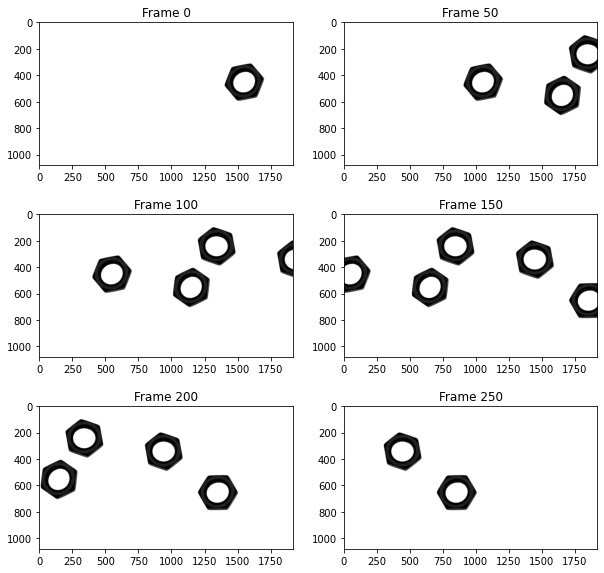

In [27]:
print(len(frameArray))
rows,cols=3,2

fig, ax = plt. subplots(3,2,figsize=(10,10))
#axs[0, 0].set_title('Axis [0, 0]')
#ax[0, 0].imshow(frameArray[0], cmap='gray')
#ax[0, 1].imshow(frameArray[50], cmap='gray')
#ax[1, 0].imshow(frameArray[100], cmap='gray')
#ax[1, 1].imshow(frameArray[150], cmap='gray')
#ax[2, 0].imshow(frameArray[200], cmap='gray')
#ax[2, 1].imshow(frameArray[200], cmap='gray')
#plt.show()
for row in range(rows):
  for col in range(cols):
    labelStr='Frame '+str(int(50*(col+2*row)))
    ax[row, col].set_title(labelStr)
    ax[row, col].imshow(frameArray[int(50*(col+2*row))], cmap='gray')
plt.show()

In [28]:
#step2
stats=[]
for grayImage in frameArray:
  stats.append([get_indexed_image(grayImage)])    #finding the statistics of the countours detected in each frame and appending it to the stats list


In [29]:
#print(stats[100])

In [30]:
#step3
contourArray=[]
contourArrayGray=[]
for i in range(len(frameArray)) :

  eachImage= frameArray[i]                                                          #taking each frame
  th, img = cv.threshold(eachImage,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)       #performing thresholding
  kernel = np.ones((3,3),np.uint8)                                                  #defining kernal for closing
  closing_img = cv.morphologyEx(img, cv.MORPH_CLOSE, kernel)                        #performing closing on the binary image
  contours_img, hierarchy_img = cv.findContours(closing_img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)  #detecting contours
  # Visualizing contours
  im_contours_belt = np.zeros((eachImage.shape[0],eachImage.shape[1],3), np.uint8)  #initiating a 3d array
  contsGray = cv.drawContours(im_contours_belt, contours_img, -1, (0,255,0), 3).astype('uint8') #drawing detected contours
  
  conts = cv.drawContours(colorFrames[i], contours_img, -1, (0,255,0), 3).astype('uint8') #drawing contours in color frames
 
  contourArray.append(conts)
  contourArrayGray.append(contsGray)

280


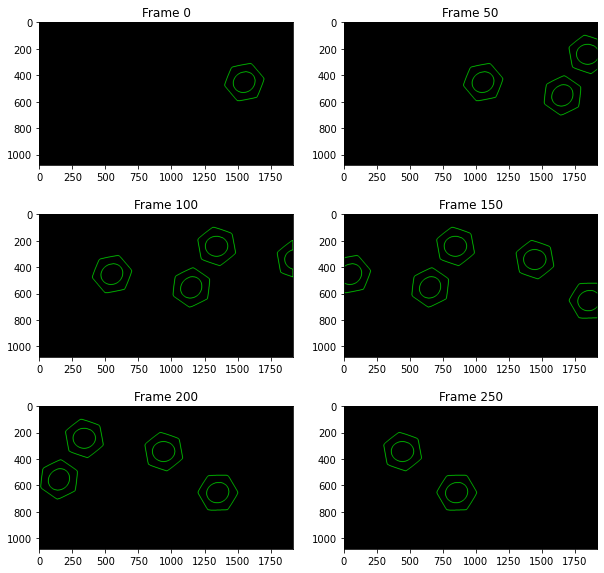

In [32]:
#visualizing the drawn contours
print(len(contourArrayGray))
rows,cols=3,2

fig, ax = plt. subplots(3,2,figsize=(10,10))
for row in range(rows):
  for col in range(cols):
    labelStr='Frame '+str(int(50*(col+2*row)))
    ax[row, col].set_title(labelStr)
    ax[row, col].imshow(contourArrayGray[int(50*(col+2*row))])
plt.show()

280


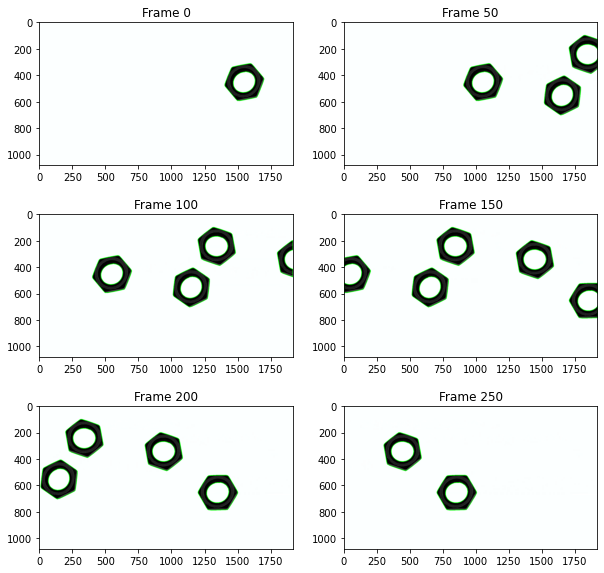

In [34]:
#visualizing the drawn contours in color frames
print(len(contourArray))
rows,cols=3,2

fig, ax = plt. subplots(3,2,figsize=(10,10))
for row in range(rows):
  for col in range(cols):
    labelStr='Frame '+str(int(50*(col+2*row)))
    ax[row, col].set_title(labelStr)
    ax[row, col].imshow(contourArray[int(50*(col+2*row))])
plt.show()

# Object detection and tracking

In [35]:
#step6 extracting details from each frame
FrameDetails=[]         #initalising list to store frame details
for eachFrame in frameArray:
  retval, labels, stats, centroids = get_indexed_image(eachFrame)               #extracting frame details 
  label = 1 # remember that the label of the background is 0
  belt = ((labels >= label)*255).astype('uint8')          
  belt_cont, template_hierarchy = cv.findContours(belt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)   #finding contour details in the frame  

  noOfNuts=0  #initalising noOfNuts found assuming 0 at the start
  frame =[]   #initalising list to store nut details in a single frame

  for contours in belt_cont:
    match = cv.matchShapes(contours_t[0], contours, cv.CONTOURS_MATCH_I1, 0.0)  #matching template with the detected contours to find matches

    if match <= 0.5:    #indicating a good match
      noOfNuts+=1       #increasing the number of nuts by 1 if a new nut is found
      momentArray = cv.moments(contours)  #computing moments of the contours
      ca = momentArray['m00']             #retriving the area of the contour
      cx, cy = int(momentArray['m10']/momentArray['m00']),int(momentArray['m01']/momentArray['m00']) #calculating x,y 
      #print(cx,cy)
      frame.append(np.array([cx, cy, ca, noOfNuts]))  #storing the nut deatails in frame 
  FrameDetails.append(frame)                          #appending all the nut details to the single frame details





In [36]:
print(FrameDetails[0][-1][-1])
#print(outputVideo[0].shape)

1.0


In [37]:
#counting total nuts in the clip
totalNuts = int(FrameDetails[0][-1][-1]) #inital nuts at the begning
delta_x=np.array([15])                   #defining delta value
i = np.array([0])                        #defining index value

object_prev_frame = FrameDetails[0]            

for index in range(1,len(FrameDetails)):
    object_curr_frame = FrameDetails[index] #assigning current frame details to a variable
    #print('index',index)

    for nutDetails in object_curr_frame: #acessing each nut in the current frame
      #print(nutDetails)
      if is_new(object_prev_frame, nutDetails, delta_x, i) == True: #comparing that nut with the nute in the previous frame
        #print('new nut is found')
        totalNuts+=1                                                #if new nut is found increasing the totalNuuts variable
    object_prev_frame=object_curr_frame                             #assigning current frame to previous for next comparison

print("total number of nuts : ",totalNuts)

total number of nuts :  5


In [38]:
#counting total nuts in the clip and tracking them 
totalNuts = int(FrameDetails[0][-1][-1])  #inital nuts at the begning
delta_x=np.array([15])                    #defining delta value
i = np.array([0])                         #defining index value

object_prev_frame = FrameDetails[0]

for index in range(1,len(FrameDetails)):
    object_curr_frame = FrameDetails[index]
    #print('index',index)

    for nutDetails in object_curr_frame:
      #print(nutDetails)
      if is_new(object_prev_frame, nutDetails, delta_x, i) == True: #new nut is found
        #print('new nut is found')
        totalNuts+=1
        nutDetails[-1] = totalNuts                                                  #the new index is created for the nut 
      else:
        indexOfPreviousFrame= prev_index(object_prev_frame, nutDetails, delta_x, i) #if a already existing nut is found retreving the nutIndex from previous frame
        nutIndexOfPrev=object_prev_frame[int(indexOfPreviousFrame)][-1]             #assiging the index to a vairable
        nutDetails[-1] = nutIndexOfPrev                                             #updating the index of the nut that nuts statistics array
    object_prev_frame=object_curr_frame

print("total number of nuts : ",totalNuts)

total number of nuts :  5


In [39]:
#annotating the frames for vedio output
outputArray=[]
frameIndex=0
totalNumofFrames=280

font= cv.FONT_HERSHEY_SIMPLEX

for index in range(280):
  colorImage=contourArray[index]
  frame=FrameDetails[index]
  #contour=contourArray[index]
  #print(contour.shape)
  y=0
  for eachNut in frame:
    colorImage=cv.putText(colorImage,str(int(eachNut[-1])),(int(eachNut[0]),int(eachNut[1])),font, 2, (255,0,0), 4,cv.LINE_AA)
    
    colorImage=cv.putText(colorImage,"Object {}: {} {} {}".format(int(eachNut[-1]), int(eachNut[0]), int(eachNut[1]), eachNut[2]),(25,870+y*60),font, 1.2, (0,0,0), 2,cv.LINE_AA)
    y+=1 #changing the verticle position


  #inserting frame number
  colorImage = cv.putText(colorImage, "Frame "+str(frameIndex) , (25,800) , font, 1.5, (0,0,0), 3,cv.LINE_AA)

  #inserting index number 
  colorImage = cv.putText(colorImage, "180398A" , (25,60) , font, 1.2, (0,0,0), 3,cv.LINE_AA)

  frameIndex+=1
  outputArray.append(colorImage)


280


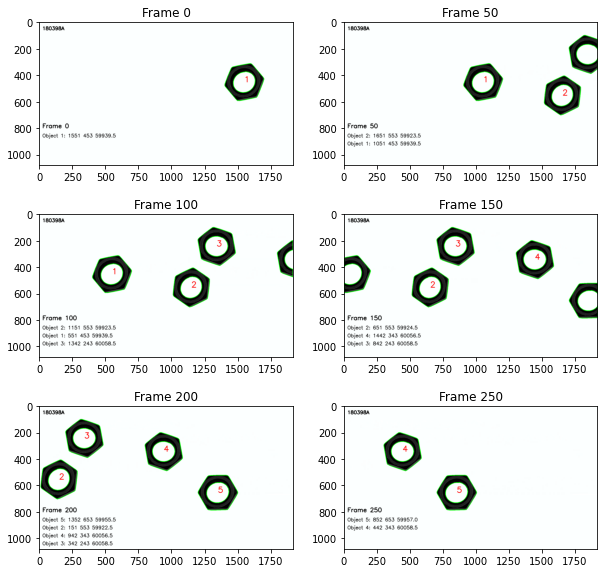

In [41]:
#visualizing the color frames
print(len(outputArray))
rows,cols=3,2

fig, ax = plt. subplots(3,2,figsize=(10,10))
for row in range(rows):
  for col in range(cols):
    labelStr='Frame '+str(int(50*(col+2*row)))
    ax[row, col].set_title(labelStr)
    ax[row, col].imshow(outputArray[int(50*(col+2*row))])
plt.show()

In [42]:
#saving as video file
fileName = '180398A_en2550_a05.mp4' 
fourcc = cv.VideoWriter_fourcc(*'MP4V') # 4-character code of codec used to compress the frames
fps = 30 # Framerate 
height, width = frameArray[0].shape
frameSize = (width, height)
Color = True # to write color images to the video

# Creating the Video Writer object
out = cv.VideoWriter(fileName, fourcc, fps, frameSize, Color)
for frame in outputArray:
    out.write(frame)

# Release everything if job is finished
out.release()
print("Render completed.")

Render completed.
